# RBLAILanjut_GioCobaHybrid

In [ ]:
import zipfile
import os

path_zip = "/home/giovaldi/jupygio/AILanjutData.zip"
directory_to_extract_to = "./RBL_AI_Lanjut_Extracted"

if os.path.exists(path_zip):
    if not os.path.exists(directory_to_extract_to):
        os.makedirs(directory_to_extract_to)
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    print(f"Sukses! File diekstrak ke: {os.path.abspath(directory_to_extract_to)}")
else:
    print(f"Error: File zip tidak ditemukan di {path_zip}")

Sukses! File diekstrak ke: /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted


In [ ]:
import os
import pandas as pd

base_dir = "/home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted/AI Lanjut Data"

data = []

categories = ['TBC', 'Pneumonia', 'Normal', 'Covid']

for category in categories:
    folder_path = os.path.join(base_dir, category)

    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                file_path = os.path.join(folder_path, filename)
                data.append({
                    'filepath': file_path,
                    'label': category
                })

df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total gambar ditemukan: {len(df)}")
print("\nContoh 5 data pertama:")
print(df.head())

print("\nJumlah data per kategori:")
print(df['label'].value_counts())

Total gambar ditemukan: 5401

Contoh 5 data pertama:
                                            filepath      label
0  /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted...  Pneumonia
1  /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted...      Covid
2  /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted...  Pneumonia
3  /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted...      Covid
4  /home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted...      Covid

Jumlah data per kategori:
label
Normal       1802
Pneumonia    1800
Covid        1149
TBC           650
Name: count, dtype: int64


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 4090


In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Hasil Awal

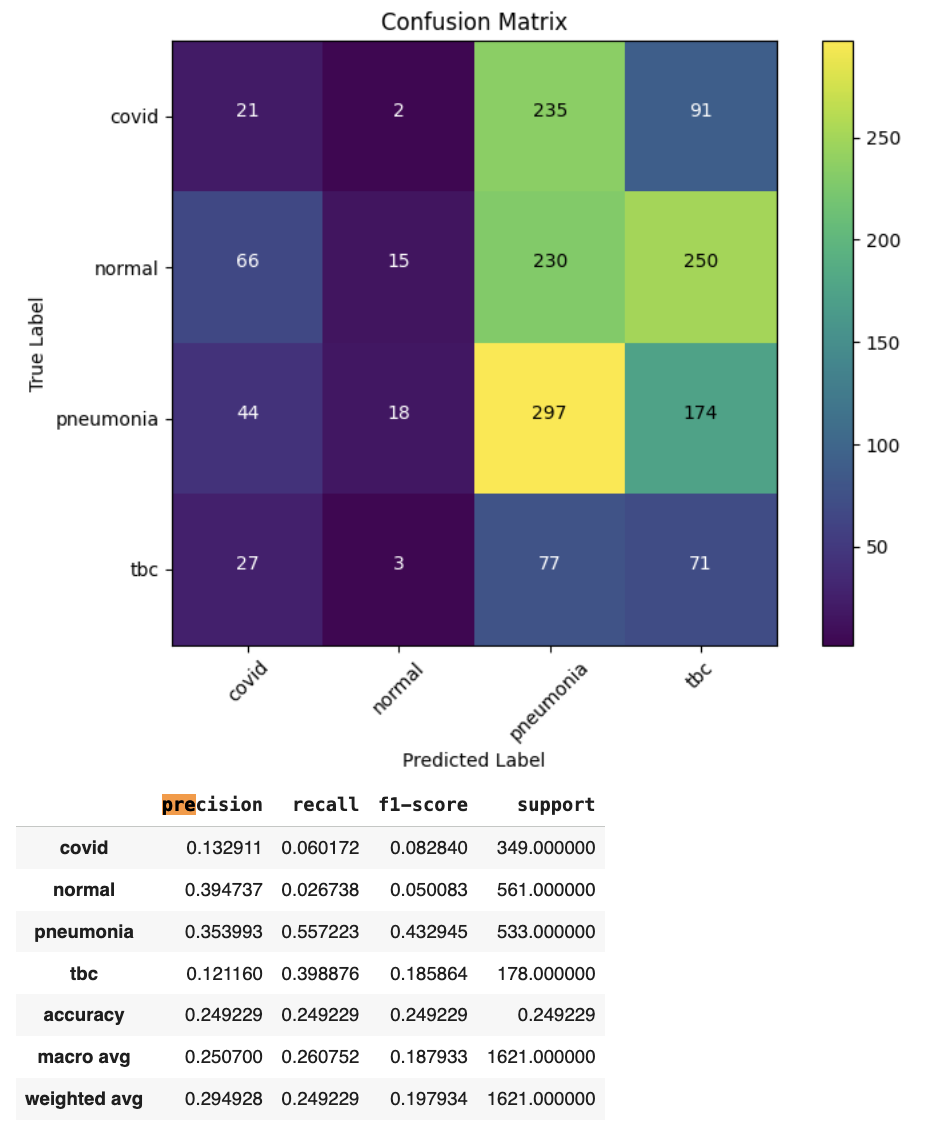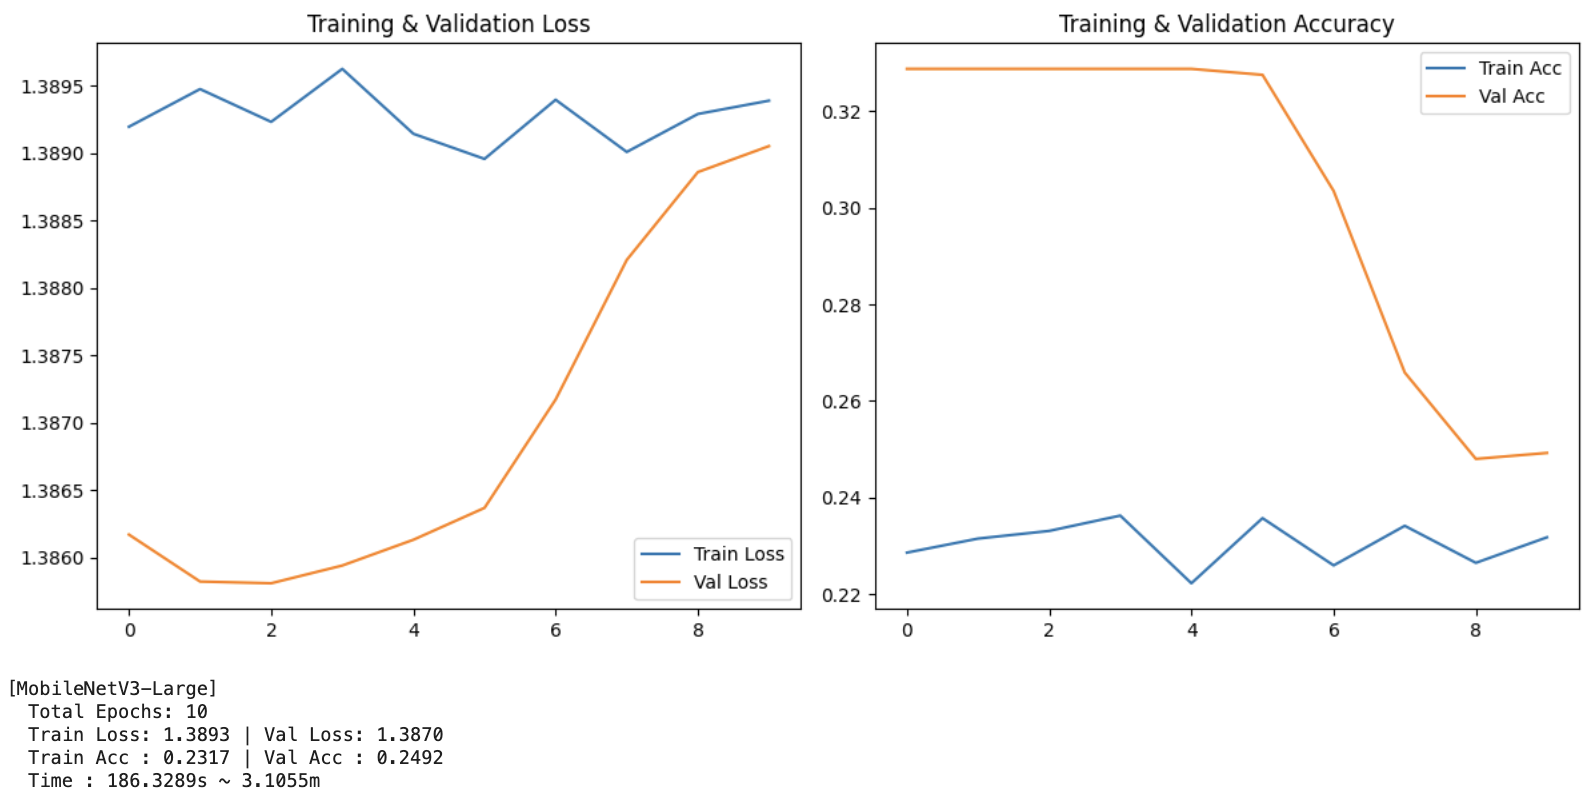

# Augmentasi

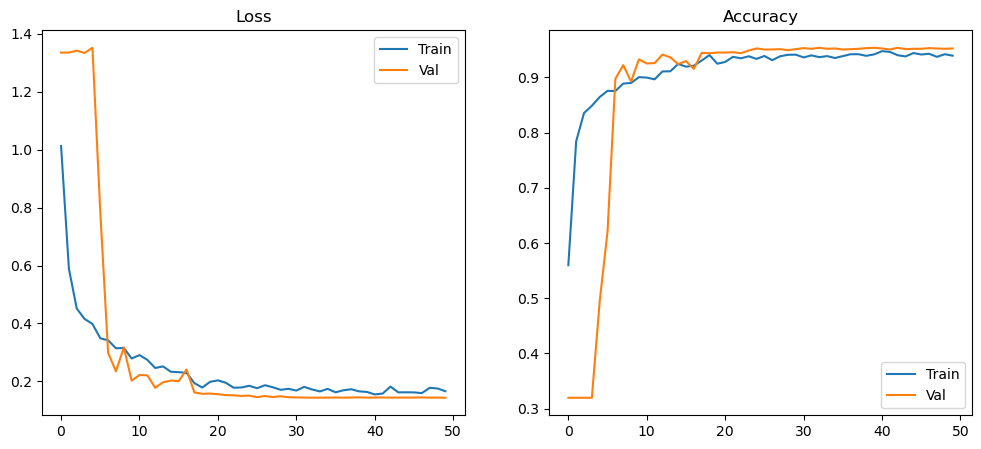

Final Val Acc: 0.9525


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "/home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted/AI Lanjut Data"

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(data_root)

train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size],
                                        generator=torch.Generator().manual_seed(42))

class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.dataset[index]
        return self.transform(x), y
    def __len__(self):
        return len(self.dataset)

train_data = MapDataset(train_subset, transform_train)
val_data = MapDataset(val_subset, transform_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_data)}, Val: {len(val_data)}")

def build_mobilenetv3_large_optimized(num_classes):
    model = models.mobilenet_v3_large(weights=None)

    in_features = model.classifier[-1].in_features

    model.classifier[-1] = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )
    return model

model = build_mobilenetv3_large_optimized(len(full_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

def train_model(model, optimizer, scheduler, name="model", epochs=50):
    start_time = time.perf_counter()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_running_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].plot(train_losses, label="Train"); ax[0].plot(val_losses, label="Val"); ax[0].set_title("Loss"); ax[0].legend()
        ax[1].plot(train_accs, label="Train"); ax[1].plot(val_accs, label="Val"); ax[1].set_title("Accuracy"); ax[1].legend()
        display(fig); plt.close(fig)

    return train_losses, val_losses, train_accs, val_accs, time.perf_counter() - start_time

train_losses, val_losses, train_accs, val_accs, elapsed = train_model(model, optimizer, scheduler, epochs=50)

print(f"Final Val Acc: {val_accs[-1]:.4f}")

# Coba Hybrid

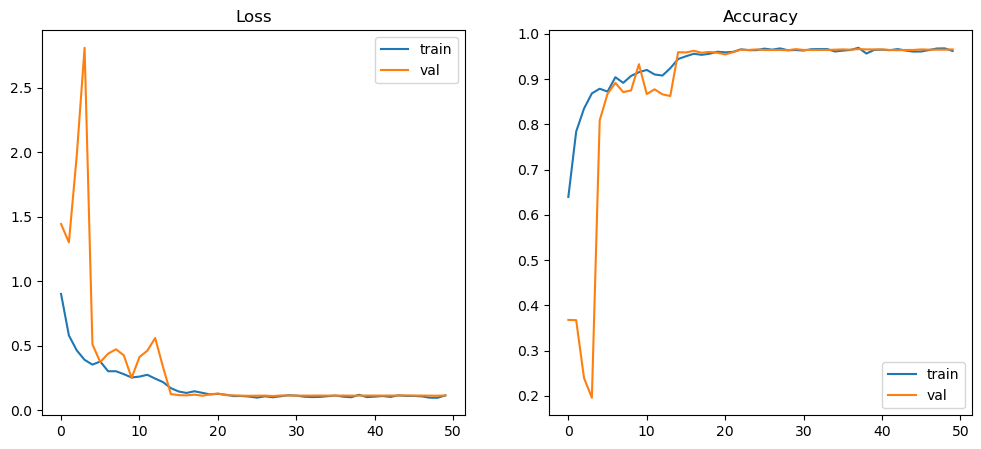

Training finished in 324.9s.


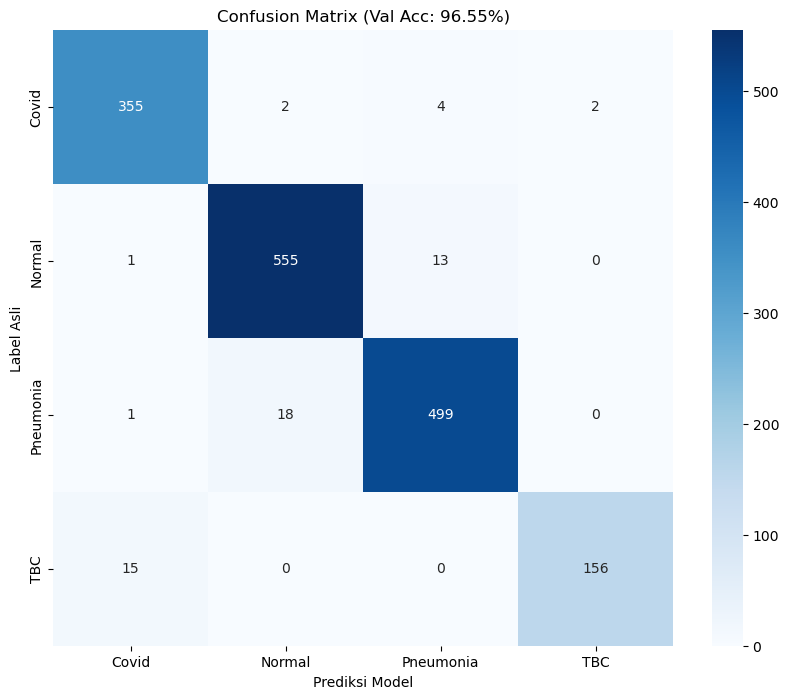


--- Detailed Classification Report ---


,precision,recall,f1-score,support
Covid,0.9543,0.9780,0.9660,363.0000
Normal,0.9652,0.9754,0.9703,569.0000
Pneumonia,0.9671,0.9633,0.9652,518.0000
TBC,0.9873,0.9123,0.9483,171.0000
accuracy,0.9655,0.9655,0.9655,0.9655
macro avg,0.9685,0.9572,0.9624,1621.0000
weighted avg,0.9657,0.9655,0.9654,1621.0000



✅ Model disimpan.


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models
from torch.amp import autocast, GradScaler
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT = "/home/giovaldi/jupygio/RBL_AI_Lanjut_Extracted/AI Lanjut Data"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-4

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(DATA_ROOT)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print("Num classes:", num_classes)

train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

class MapDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y

train_data = MapDataset(train_subset, transform_train)
val_data = MapDataset(val_subset, transform_val)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_data)}, Val: {len(val_data)}")

class CrossChannelAttentionFusion(nn.Module):
    def __init__(self, in_ch_a, in_ch_b, proj_dim=1024, hidden=1024, out_classes=2):
        super().__init__()
        self.proj_a = nn.Linear(in_ch_a, proj_dim)
        self.proj_b = nn.Linear(in_ch_b, proj_dim)

        self.att_mlp = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim // 2, proj_dim),
            nn.Sigmoid()
        )

        self.head = nn.Sequential(
            nn.Linear(proj_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden, out_classes)
        )

    def forward(self, a, b):
        a_p = self.proj_a(a)
        b_p = self.proj_b(b)

        joint = torch.cat([a_p, b_p], dim=1)
        att = self.att_mlp(joint)

        fused = att * a_p + (1.0 - att) * b_p

        out = self.head(fused)
        return out

class HybridMobileNetEffB4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.mobilenet = models.mobilenet_v3_large(weights=None)
        self.efficientnet = models.efficientnet_b4(weights=None)
        for p in self.mobilenet.features.parameters():
            p.requires_grad = True
        for p in self.efficientnet.features.parameters():
            p.requires_grad = True

        with torch.no_grad():
            self.mobilenet.eval()
            self.efficientnet.eval()
            dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

            m_out = self.mobilenet.features(dummy)
            m_out = m_out.mean([2, 3])
            mobilenet_feat_dim = m_out.shape[1]

            e_out = self.efficientnet.features(dummy)
            e_out = F.adaptive_avg_pool2d(e_out, 1)
            e_out = torch.flatten(e_out, 1)
            effnet_feat_dim = e_out.shape[1]

        print(f"Detected Features -> MobileNet: {mobilenet_feat_dim}, EffNetB4: {effnet_feat_dim}")

        self.fusion = CrossChannelAttentionFusion(
            in_ch_a=mobilenet_feat_dim,
            in_ch_b=effnet_feat_dim,
            proj_dim=1024,
            hidden=1024,
            out_classes=num_classes
        )

    def forward(self, x):
        m = self.mobilenet.features(x)
        m = m.mean([2,3])

        e = self.efficientnet.features(x)
        e = F.adaptive_avg_pool2d(e, 1)
        e = torch.flatten(e, 1)

        out = self.fusion(m, e)
        return out

model = HybridMobileNetEffB4(num_classes=num_classes).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

criterion = nn.CrossEntropyLoss()

scaler = torch.amp.GradScaler('cuda')

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

train_losses, val_losses = [], []
train_accs, val_accs = [], []
start_time = time.perf_counter()

for epoch in range(NUM_EPOCHS):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    v_loss, v_acc = validate(model, val_loader, criterion)

    train_losses.append(t_loss); val_losses.append(v_loss)
    train_accs.append(t_acc); val_accs.append(v_acc)

    scheduler.step(v_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {t_loss:.4f} | Val Acc: {v_acc:.4f} | LR: {current_lr:.5f}")

    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].plot(train_losses, label="train"); ax[0].plot(val_losses, label="val"); ax[0].legend(); ax[0].set_title("Loss")
    ax[1].plot(train_accs, label="train"); ax[1].plot(val_accs, label="val"); ax[1].legend(); ax[1].set_title("Accuracy")
    display(fig); plt.close(fig)

elapsed = time.perf_counter() - start_time
print(f"Training finished in {elapsed:.1f}s.")

def get_all_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

y_true, y_pred = get_all_predictions(model, val_loader)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model'); plt.ylabel('Label Asli'); plt.title(f'Confusion Matrix (Val Acc: {val_accs[-1]*100:.2f}%)')
plt.show()

print("\n--- Detailed Classification Report ---")
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
display(df_report.style.format("{:.4f}").background_gradient(cmap='Greens', subset=['f1-score']))

torch.save(model.state_dict(), "hybrid_mobilenet_effnetb4_scratch_final.pth")
print("\n✅ Model disimpan.")

In [ ]:
final_train_acc = train_accs[-1] * 100
final_val_acc = val_accs[-1] * 100

best_val_acc = max(val_accs) * 100
best_epoch = val_accs.index(max(val_accs)) + 1

print(f"Final Train Accuracy : {final_train_acc:.2f}%")
print(f"Final Val Accuracy   : {final_val_acc:.2f}%")
print(f"Best Val Accuracy  : {best_val_acc:.2f}% (Dicapai pada Epoch {best_epoch})")

Final Train Accuracy : 96.19%
Final Val Accuracy   : 96.55%
Best Val Accuracy  : 96.61% (Dicapai pada Epoch 30)
